## Problem Statement:

### What is the optimal bowling strategy in Chinnaswamy, Which type of bowlers to use & when (phase of play)?

- Venue analysis
- Historic trends
- Bowlers analysis

### Keywords Involved:
- Bowling Strategy
    - Bowlers analysis
    - By Phases of play - (PP/Middle/Death)
    - By Innings - (Bowl 1st/2nd)
- Venue Analysis
    - Performance in venues
    - Toss factor
    - Venue trends --- (runrates, wickets, ..)

In [1]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import matplotlib.pyplot as plt

## Part 1: Bowler Statistics

In [2]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

In [3]:
matches.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


In [4]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


## Part 1.1 : Extracting required fields

### Filter only "Bowlers Wickets"

In [5]:
deliveries.dismissal_kind.unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'caught and bowled',
       'stumped', 'retired hurt', 'hit wicket', 'obstructing the field'],
      dtype=object)

In [6]:
def is_wicket(player_dismissed, dismissal_kind):
    if type(player_dismissed) != str:
        return 0
    elif ~(type(player_dismissed) != str) & (dismissal_kind not in ['run out', 'retired hurt', 'obstructing the field']):
        return 1
    else:
        return 0

In [7]:
deliveries['isBowlerWk'] = deliveries.apply(lambda x: is_wicket(x['player_dismissed'], x['dismissal_kind']), axis = 1)

In [8]:
deliveries[deliveries.dismissal_kind == 'run out'].head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk
199,1,2,Royal Challengers Bangalore,Sunrisers Hyderabad,12,4,KM Jadhav,TM Head,MC Henriques,0,0,0,0,0,0,1,0,1,KM Jadhav,run out,BCJ Cutting,0
247,1,2,Royal Challengers Bangalore,Sunrisers Hyderabad,20,4,A Choudhary,YS Chahal,BCJ Cutting,0,0,0,0,0,0,0,0,0,YS Chahal,run out,CJ Jordan (sub),0


In [9]:
deliveries[deliveries.dismissal_kind == 'lbw'].head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk
289,2,1,Mumbai Indians,Rising Pune Supergiant,7,5,JC Buttler,N Rana,Imran Tahir,0,0,0,0,0,0,0,0,0,JC Buttler,lbw,NaN,1
544,3,1,Gujarat Lions,Kolkata Knight Riders,9,1,BB McCullum,SK Raina,Kuldeep Yadav,0,0,0,0,0,0,0,0,0,BB McCullum,lbw,NaN,1


## Part 1.2 : Customized functions

### Custom fields: BPD, BPB, DOT%, Eco, Bowl Avg, Bowl SR

In [10]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def get_dot_percentage(dots, balls):
    if balls > 0:
        return dots/balls
    else:
        return 0
    
def runs_per_ball(balls, runs_conceeded):
    if balls > 0:
        return runs_conceeded/balls
    else:
        return math.inf
    
def runs_per_dismissal(runs_conceeded, dismissals):
    if dismissals > 0:
        return runs_conceeded/dismissals
    else:
        return math.inf

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [11]:
df = playerStatistics(deliveries)

In [12]:
df.head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Ashish Reddy,20,400,270,18,89,110,23,2,26,20,32.962963,22.222222,15.000000,8.888889
1,A Chandila,12,245,234,11,105,91,10,1,17,10,44.871795,22.272727,21.272727,6.282051
2,A Choudhary,5,144,108,5,49,31,9,0,13,6,45.370370,28.800000,21.600000,8.000000
3,A Flintoff,3,106,66,2,21,27,4,0,7,7,31.818182,53.000000,33.000000,9.636364
4,A Kumble,42,1089,983,45,410,406,57,3,72,35,41.709054,24.200000,21.844444,6.646999


In [13]:
df.sort_values('Dot%', ascending = False).head(20)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
20,AC Gilchrist,1,0,1,1,1,0,0,0,0,0,100.000000,0.000000,1.000000,0.000000
170,LA Carseldine,1,6,7,1,5,1,0,0,1,0,71.428571,6.000000,7.000000,5.142857
305,SS Mundhe,1,6,7,1,5,1,0,0,1,0,71.428571,6.000000,7.000000,5.142857
210,NB Singh,2,18,25,1,17,6,0,0,2,0,68.000000,18.000000,25.000000,4.320000
296,SM Harwood,3,74,67,3,41,12,5,1,6,2,61.194030,24.666667,22.333333,6.626866
171,LH Ferguson,4,96,87,3,52,20,2,0,9,4,59.770115,32.000000,29.000000,6.620690
316,Shoaib Akhtar,3,54,46,5,27,8,3,0,6,2,58.695652,10.800000,9.200000,7.043478
105,FH Edwards,6,160,150,5,84,36,8,0,20,2,56.000000,32.000000,30.000000,6.400000
92,DJ Muthuswami,6,108,84,4,47,14,5,1,14,3,55.952381,27.000000,21.000000,7.714286
318,Sohail Tanvir,11,275,265,22,148,70,13,0,27,7,55.849057,12.500000,12.045455,6.226415


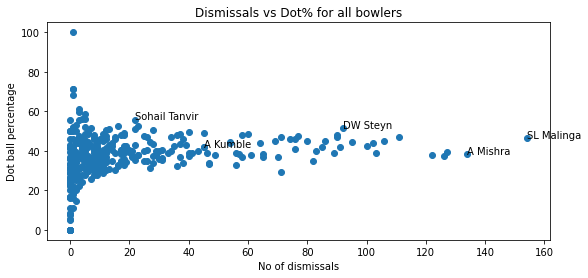

In [14]:
plt.figure(figsize = (9, 4))
plt.scatter(df['dismissals'], df['Dot%'])
plt.title('Dismissals vs Dot% for all bowlers')
plt.xlabel('No of dismissals')
plt.ylabel('Dot ball percentage')


annotations=list(df['bowler'])
selected_players = ['A Kumble', 'SL Malinga', 'A Mishra', 'Sohail Tanvir', 'DW Steyn']

for i, label in enumerate(annotations):
    if label in selected_players:
        plt.annotate(label, (df['dismissals'][i], df['Dot%'][i]))
    
    
plt.show()

### 1.3 : Performance in different phases of play

In [15]:
def phase(over):
    # over number in our dataset starts from 0
    if over <= 5:
        return 'Powerplay'
    elif over <= 14:
        return 'Middle'
    else:
        return 'Death'

In [16]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [17]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [18]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [19]:
pp_df.head(2)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Chandila,12,139,144,10,71,51,5,0,13,4,49.305556,13.900000,14.400000,5.791667
1,A Choudhary,4,46,37,3,19,9,2,0,5,2,51.351351,15.333333,12.333333,7.459459


In [20]:
mid_df.head(2)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Ashish Reddy,17,189,147,7,56,57,11,1,16,6,38.095238,27.0,21.0,7.714286
1,A Chandila,8,87,72,1,28,31,3,1,4,5,38.888889,87.0,72.0,7.250000


In [21]:
dth_df.head(2)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Ashish Reddy,16,211,123,11,33,53,12,1,10,14,26.829268,19.181818,11.181818,10.292683
1,A Chandila,2,19,18,0,6,9,2,0,0,1,33.333333,inf,18.000000,6.333333


### 1.4 : Performance by Bat 1st/2nd

In [22]:
def ByInning(df, current_inning):
    
    df = df[df.inning == current_inning]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [23]:
ing1_df = ByInning(deliveries, 1)
ing2_df = ByInning(deliveries, 2)

In [24]:
ing1_df.head(2)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Ashish Reddy,8,148,98,7,31,42,8,0,10,7,31.632653,21.142857,14.0,9.061224
1,A Chandila,6,142,120,3,51,43,6,1,15,4,42.500000,47.333333,40.0,7.100000


In [25]:
ing2_df.head(2)

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Ashish Reddy,12,252,172,11,58,68,15,2,16,13,33.720930,22.909091,15.636364,8.790698
1,A Chandila,6,103,114,8,54,48,4,0,2,6,47.368421,12.875000,14.250000,5.421053


## Malinga's performance against all teams:

In [26]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

In [27]:
deliveries['isOut'] = deliveries['player_dismissed'].apply(lambda x: isOut(x)) 

In [28]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk,isDot,isOne,isTwo,isThree,isFour,isSix,phase,isOut
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0


In [29]:
selected_player = 'SL Malinga'

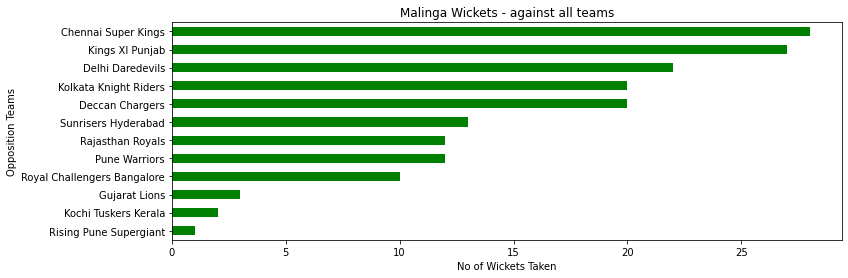

In [30]:
plt.figure(figsize = (12, 4))
deliveries[deliveries.bowler == selected_player].groupby(['batting_team'])['isOut'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Malinga Wickets - against all teams')
plt.xlabel('No of Wickets Taken')
plt.ylabel('Opposition Teams')
plt.show()

## Part 2 : Venue Analysis

In [31]:
def wintoss_winmatch(toss_decision, team1, team2, winner):
    if toss_decision == 'field':
        if team2 == winner:
            return True
        else:
            return False
        
    else:
        if team1 == winner:
            return True
        else:
            return False


In [32]:
matches['wintoss_winmatch'] = matches.apply(lambda x: wintoss_winmatch(x['toss_decision'], x['team1'], x['team2'], x['winner']), axis = 1)

In [33]:
matches[['id', 'season', 'team1', 'team2', 'wintoss_winmatch']].head()

,id,season,team1,team2,wintoss_winmatch
0,1,2017,Sunrisers Hyderabad,Royal Challengers Bangalore,False
1,2,2017,Mumbai Indians,Rising Pune Supergiant,True
2,3,2017,Gujarat Lions,Kolkata Knight Riders,True
3,4,2017,Rising Pune Supergiant,Kings XI Punjab,True
4,5,2017,Royal Challengers Bangalore,Delhi Daredevils,True


In [34]:
print('% of wintoss-winmatch =', 100*len(matches[matches.wintoss_winmatch == 1])/len(matches))

% of wintoss-winmatch = 51.100628930817614


In [35]:
pd.DataFrame(matches.groupby('season')['wintoss_winmatch'].sum().sort_values())

,wintoss_winmatch
season,
2008,28
2015,28
2014,30
2010,31
2009,33
2012,33
2016,34
2017,34
2013,36


In [36]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

In [37]:
def venueAnalysis(mdf, df):
    
    runs = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index())
    runs['Id_Ing'] = runs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    balls = pd.DataFrame(df.groupby(['match_id', 'inning'])['total_runs'].count().reset_index()).rename(columns = {'total_runs':'total_balls'})
    balls['Id_Ing'] = balls.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df['isOut'] = df['player_dismissed'].apply(lambda x: isOut(x))
    outs = pd.DataFrame(df.groupby(['match_id', 'inning'])['isOut'].sum().reset_index()).rename(columns = {'isOut':'wickets'})
    outs['Id_Ing'] = outs.apply(lambda x: str(x['match_id']) + '-' + str(x['inning']), axis = 1)
    
    df = pd.merge(runs, balls[['Id_Ing', 'total_balls']], on = 'Id_Ing').merge(outs[['Id_Ing', 'wickets']], on = 'Id_Ing')
    
    mdf = mdf.rename(columns = {'id':'match_id'})
    df = pd.merge(df, mdf[['match_id', 'venue']], on = 'match_id')
    df = df[['match_id', 'venue', 'inning', 'total_runs', 'total_balls', 'wickets']]
    
    return df

In [38]:
ven_df = venueAnalysis(matches, deliveries)

In [39]:
ven_df.head()

,match_id,venue,inning,total_runs,total_balls,wickets
0,1,"Rajiv Gandhi International Stadium, Uppal",1,207,125,4
1,1,"Rajiv Gandhi International Stadium, Uppal",2,172,123,10
2,2,Maharashtra Cricket Association Stadium,1,184,125,8
3,2,Maharashtra Cricket Association Stadium,2,187,122,3
4,3,Saurashtra Cricket Association Stadium,1,183,122,4


In [40]:
pd.DataFrame(ven_df.groupby('venue')['total_runs'].mean().sort_values(ascending = False)).rename(columns = {'total_runs':'Avg_Runs'}).reset_index().head(20)

,venue,Avg_Runs
0,Brabourne Stadium,174.636364
1,Barabati Stadium,162.714286
2,Green Park,162.250000
3,"Punjab Cricket Association IS Bindra Stadium, Mohali",161.136364
4,Himachal Pradesh Cricket Association Stadium,160.944444
5,Maharashtra Cricket Association Stadium,158.733333
6,Wankhede Stadium,157.815789
7,Holkar Cricket Stadium,157.600000
8,"Punjab Cricket Association Stadium, Mohali",156.957143
9,"MA Chidambaram Stadium, Chepauk",155.887755


In [41]:
selected_venue = 'M Chinnaswamy Stadium'

In [42]:
ven_df[ven_df['venue'] == selected_venue].head(1)

,match_id,venue,inning,total_runs,total_balls,wickets
8,5,M Chinnaswamy Stadium,1,157,124,8


### Avg 1st & 2nd innings scores at Chinnaswamy:

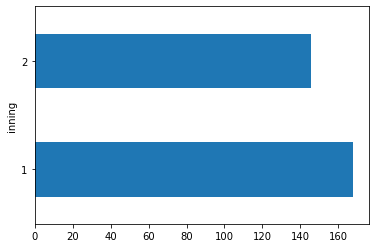

In [43]:
ven_df[ven_df['venue'] == selected_venue].groupby(['inning'])['total_runs'].mean()[:2].plot(kind = 'barh')
plt.show()

In [44]:
matches.rename(columns = {'id':'match_id'}, inplace = True)

In [45]:
combined_data = deliveries.merge(matches[['match_id', 'venue']], on = 'match_id', how = 'left')

In [46]:
combined_data.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,isBowlerWk,isDot,isOne,isTwo,isThree,isFour,isSix,phase,isOut,venue
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0,"Rajiv Gandhi International Stadium, Uppal"
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,1,0,0,0,0,0,Powerplay,0,"Rajiv Gandhi International Stadium, Uppal"


In [47]:
def ByCustom(df, selected_venue):
       
    df = df[df.venue == selected_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['bowler', 'match_id'])['total_runs'].sum().reset_index()).groupby(['bowler'])['total_runs'].sum().reset_index().rename(columns={'total_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['bowler'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['bowler'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['bowler'])['isBowlerWk'].sum()).reset_index().rename(columns = {'isBowlerWk':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['bowler'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['bowler'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['bowler'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['bowler'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['bowler'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['bowler'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'bowler').merge(balls, on = 'bowler').merge(dismissals, on = 'bowler').merge(dots, on = 'bowler').merge(ones, on = 'bowler').merge(twos, on = 'bowler').merge(threes, on = 'bowler').merge(fours, on = 'bowler').merge(sixes, on = 'bowler')
    
    # Dot Percentage = Number of dots in total deliveries
    df['Dot%'] = df.apply(lambda x: get_dot_percentage(x['dots'], x['balls'])*100, axis = 1)
    
    # Average = Runs per wicket
    df['Avg'] = df.apply(lambda x: runs_per_dismissal(x['runs'], x['dismissals']), axis = 1)
    
    # StrikeRate = Balls per wicket
    df['SR'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # Economy = runs per over
    df['Eco'] = df.apply(lambda x: runs_per_ball(x['balls'], x['runs'])*6, axis = 1)
    
    return df

In [48]:
df = ByCustom(combined_data, selected_venue)

In [49]:
df.head()

,bowler,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,Dot%,Avg,SR,Eco
0,A Ashish Reddy,4,86,48,2,18,14,3,1,6,6,37.500000,43.000000,24.000000,10.750000
1,A Chandila,1,21,24,0,10,11,2,0,0,1,41.666667,inf,24.000000,5.250000
2,A Choudhary,3,57,55,3,30,13,5,0,5,2,54.545455,19.000000,18.333333,6.218182
3,A Kumble,12,363,291,9,108,132,10,0,28,13,37.113402,40.333333,32.333333,7.484536
4,A Mishra,5,159,104,4,30,49,7,0,11,7,28.846154,39.750000,26.000000,9.173077


In [50]:
df[['Dot%', 'Avg', 'SR', 'Eco']].mean()

Dot%    38.637293
Avg     inf      
SR      23.508354
Eco     8.724476 
dtype: float64

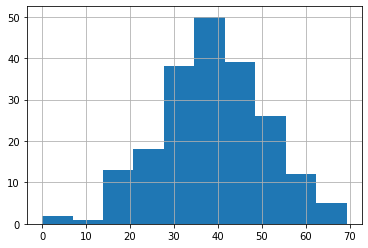

In [51]:
df['Dot%'].hist()
plt.show()

## Problem statement as Assignment: